<a href="https://www.kaggle.com/code/phillipgregory1994/lstm-sentiment-analysis-for-mental-health?scriptVersionId=189034385" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


# Sentiment Analysis for Mental Health

## Objectives
* Conduct an Exploratory Data Analysis (EDA)
* Perform data cleaning, feature engineering, and NLP pre-processing
* Create three deep learning model variations that support sentiment analysis in mental health
* Determine the most suitable model
* Conclude the notebook

## EDA

In [2]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
# Import the data
address = '/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv'
df = pd.read_csv(address)

# Show top 5 rows
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
# Rename the ID column
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Print the shape of the data
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns.')

# Check new column names
print(df.columns)

The data has 53043 rows and 3 columns.
Index(['ID', 'statement', 'status'], dtype='object')


In [5]:
# Check for missing values
print(df.isnull().sum())
print('-'*20)
null_pct = df.statement.isnull().sum() / df.shape[0]
print(f'The percentage of missing values in the statement column is {round(null_pct*100,2)}%.')

ID             0
statement    362
status         0
dtype: int64
--------------------
The percentage of missing values in the statement column is 0.68%.


In [6]:
# Drop missing values due to low percentage missing
df = df.dropna()

In [7]:
# Check for duplicates
print(f"The data has {df['statement'].duplicated().sum()} duplicated rows.")

# Drop the duplicated rows
df = df.drop_duplicates(subset='statement')

The data has 1608 duplicated rows.


In [8]:
# Count the number of each status
status = df['status'].value_counts()
total = status.values.sum()

# Calculate each status description as a percentage
status_percentage = [f"{round(i/total*100,2)}%" for i in status.values]
status_percentage

# Visualise in a bar chart
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(x=status.index, y=status.values, text=status_percentage, textposition='auto'))
fig.update_layout(title='Status Distribution', xaxis_title='Status', yaxis_title='Count')
fig.show()

As 'status' is unbalanced, resampling will be used when training the model to give a more balanced class weight representation

In [9]:
# Investigate the length of each statement
df['length'] = df['statement'].apply(lambda x: len(x.split()))
df['length'].describe()

count    51073.000000
mean       112.667045
std        164.060533
min          1.000000
25%         15.000000
50%         61.000000
75%        147.000000
max       6300.000000
Name: length, dtype: float64

In [10]:
# Isolate outliers
IQR = df['length'].quantile(0.75) - df['length'].quantile(0.25)
upper_limit = df['length'].quantile(0.75) + 1.5*IQR
lower_limit = df['length'].quantile(0.25) # 15 is the lower limit as 1.5*IQR as it would be negative
outliers = df[(df['length'] > upper_limit) | (df['length'] < lower_limit)]
upper_outliers = df[df['length'] > upper_limit]
lower_outliers = df[df['length'] < lower_limit]

# Quantify outliers
print(f'The number of outliers is {outliers.shape[0]}.')
print(f'The number of upper outliers is {upper_outliers.shape[0]}.')
print(f'The number of lower outliers is {lower_outliers.shape[0]}.')

The number of outliers is 15745.
The number of upper outliers is 3392.
The number of lower outliers is 12353.


In [11]:
# Investigate how the upper outliers correlate with the status
upper_status = upper_outliers['status'].value_counts()
upper_total = upper_status.values.sum()
upper_percentage = [f"{round(i/upper_total*100,2)}%" for i in upper_status.values]

# Investigate how the lower outliers correlate with the status
lower_status = lower_outliers['status'].value_counts()
lower_total = lower_status.values.sum()
lower_percentage = [f"{round(i/lower_total*100,2)}%" for i in lower_status.values]

# Plot upper outliers on bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=upper_status.index, y=upper_status.values, text=upper_percentage, textposition='auto'))
fig.update_layout(title='Mental Status of Upper Outliers', xaxis_title='Status', yaxis_title='Count')
fig.show()

In [12]:
# Plot lower outliers on bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=lower_status.index, y=lower_status.values, text=lower_percentage, textposition='auto'))
fig.update_layout(title='Mental Status of Lower Outliers', xaxis_title='Status', yaxis_title='Count')
fig.show()

### EDA Findings Summary
* Across all records, 'Normal' is the most common mental status, but the most common mental health issue is 'Depression" at 29.54%
* For people who wrote the longest statements (upper outliers), nobody falls into the normal category, and the almost half of these records have status 'Depression'. There could be a correlation between longer social media posts and depression
* For the shortest statements (<15 words), 85.53% of records are of 'Normal' status. Most short posts are not associated with a mental health issue

## NLP Pre-processing

In [13]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import TextVectorization

# Set random seed
tf.random.set_seed(42)

# Import and unzip nltk libraries
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

2024-07-20 07:30:26.278925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 07:30:26.279061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 07:30:26.406915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [14]:
# Change the statement to lowercase
df['statement_processed'] = df['statement'].str.lower()

# Remove punctuation
import string
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df['statement_processed'] = df['statement_processed'].apply(remove_punctuation)

# Tokenize the statement
from nltk.tokenize import word_tokenize
df['statement_processed'] = df['statement_processed'].apply(word_tokenize)

# Remove stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
def remove_stopwords(text):
    return [word for word in text if word not in stopwords]

df['statement_processed'] = df['statement_processed'].apply(remove_stopwords)

# Lemmatize the statement
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

df['statement_processed'] = df['statement_processed'].apply(lemmatize)

# Remove non-alphabetic characters
def remove_non_alpha(text):
    return [word for word in text if word.isalpha()]

df['statement_processed'] = df['statement_processed'].apply(remove_non_alpha)

# Join the words back together
def join_words(text):
    return ' '.join(text)

df['statement_processed'] = df['statement_processed'].apply(join_words)

In [15]:
# Create train test split
from sklearn.model_selection import train_test_split
X = df['statement_processed']
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One hot encode categorical labels
y_train_encoded = pd.get_dummies(y_train).values
y_test_encoded = pd.get_dummies(y_test).values

In [16]:
# Use TextVectorization to convert the text into a numerical format
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)

# Fit the vectorizer on the statement
vectorizer.adapt(X_train.values)

# Transform the statement
X_train_vectorized = vectorizer(X_train.values)
X_test_vectorized = vectorizer(X_test.values)

# Calculate new class weights to address imbalanced target variable 'status'
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

## LSTM Models

In [17]:
# Number of class labels
num_classes = y_train_encoded.shape[1]

# First LSTM model attempt - No regularisation
model = Sequential([
    tf.keras.Input(shape=(200,)),
    Embedding(input_dim=20000, output_dim=128),
    LSTM(units=32),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to limit overfitting and computational expense
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_vectorized, y_train_encoded, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test_vectorized, y_test_encoded), 
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

Epoch 1/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.1794 - loss: 1.9345 - val_accuracy: 0.3279 - val_loss: 1.9137
Epoch 2/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2344 - loss: 1.9223 - val_accuracy: 0.5129 - val_loss: 1.6991
Epoch 3/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4771 - loss: 1.6334 - val_accuracy: 0.5473 - val_loss: 1.2386
Epoch 4/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6264 - loss: 1.1144 - val_accuracy: 0.6819 - val_loss: 0.8883
Epoch 5/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7272 - loss: 0.7492 - val_accuracy: 0.6965 - val_loss: 0.8363
Epoch 6/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7805 - loss: 0.5421 - val_accuracy: 0.7196 - val_loss: 0.8145
Epoch 7/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8246 - loss: 0.4145 - val_accuracy: 0.7143 - val_loss: 0.8611
Epoch 8/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8543 -

**Results**
* Basic LTSM model performed well returning a best val_accuracy of 71.44%
* Training accuracy was 86.35% in this epoch, so some slight overfitting
* Try and l2 regularizer in the next model

In [18]:
# Import l2 regularizer
from tensorflow.keras.regularizers import l2

# LTSM model with l2 regularisation in the dense layer
model_b = Sequential([
    tf.keras.Input(shape=(200,)),
    Embedding(input_dim=20000, output_dim=128),
    LSTM(units=32),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))
])

# Compile the model
model_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

# Fit the model
history_b = model_b.fit(X_train_vectorized, y_train_encoded, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test_vectorized, y_test_encoded), 
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)


Epoch 1/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1513 - loss: 1.9707 - val_accuracy: 0.3279 - val_loss: 1.9293
Epoch 2/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3155 - loss: 1.8184 - val_accuracy: 0.3873 - val_loss: 1.4338
Epoch 3/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4073 - loss: 1.5054 - val_accuracy: 0.5144 - val_loss: 1.1995
Epoch 4/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5721 - loss: 1.1730 - val_accuracy: 0.5908 - val_loss: 1.0709
Epoch 5/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6428 - loss: 0.9261 - val_accuracy: 0.6498 - val_loss: 1.0076
Epoch 6/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7171 - loss: 0.7338 - val_accuracy: 0.6708 - val_loss: 1.0181
Epoch 7/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7720 - loss: 0.5981 - val_accuracy: 0.7030 - val_loss: 0.8995
Epoch 8/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8110 -

**Results**
* Marginally better results adding l2 regulariser to the dense layer.
* 71.72% val_accuracy in epoch 10 with training accuracy of 85.05%. Slightly less overfitting than model A

In [19]:
# LSTM model with dropout
from tensorflow.keras.layers import Dropout
model_c = Sequential([
    tf.keras.Input(shape=(200,)),
    Embedding(input_dim=20000, output_dim=128),
    LSTM(units=32),
    Dropout(0.3), # Dropout layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_c.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

# Fit the model
history_c = model_c.fit(X_train_vectorized, y_train_encoded, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(X_test_vectorized, y_test_encoded), 
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

Epoch 1/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.1689 - loss: 1.9334 - val_accuracy: 0.3301 - val_loss: 1.9243
Epoch 2/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.1949 - loss: 1.9189 - val_accuracy: 0.3274 - val_loss: 1.9383
Epoch 3/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2314 - loss: 1.9000 - val_accuracy: 0.3387 - val_loss: 1.9192
Epoch 4/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2429 - loss: 1.8662 - val_accuracy: 0.3397 - val_loss: 1.9287
Epoch 5/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3584 - loss: 1.7647 - val_accuracy: 0.5153 - val_loss: 1.3655
Epoch 6/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5784 - loss: 1.2696 - val_accuracy: 0.6705 - val_loss: 0.9073
Epoch 7/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7024 - loss: 0.9274 - val_accuracy: 0.6835 - val_loss: 0.8861
Epoch 8/20
1277/1277 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7541 -

**Results**
* Peak val_accuracy of 71.06% which is similar to other two models
* This model is the least overfit as the training accuracy in epoch 8 was 78.81%

**Preferred model**
* Use model c due to good val_accuracy of 71.06% and it being less overfit than the first two models due to a smaller gap from the training accuracy
* The next section visualises the training over epochs and dives deeper into the results with a classification report

In [20]:
# Define function to visualise loss and accuracy
def display_metrics(history):
    
    n=len(history.history['loss'])
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,2,1)
    ax.plot(range(n), history.history['loss'], 'r', label='Training Loss')
    ax.plot(range(n), history.history['val_loss'], 'b', label='Validation Loss')
    ax.legend()
    ax.set_title('Loss over epochs')
    
    ax = fig.add_subplot(1,2,2)
    ax.plot(range(n), history.history['accuracy'], 'r', label='Training Accuracy')
    ax.plot(range(n), history.history['val_accuracy'], 'b', label='Validation Accuracy')
    ax.legend(loc='lower right')
    ax.set_title('Accuracy over epochs')

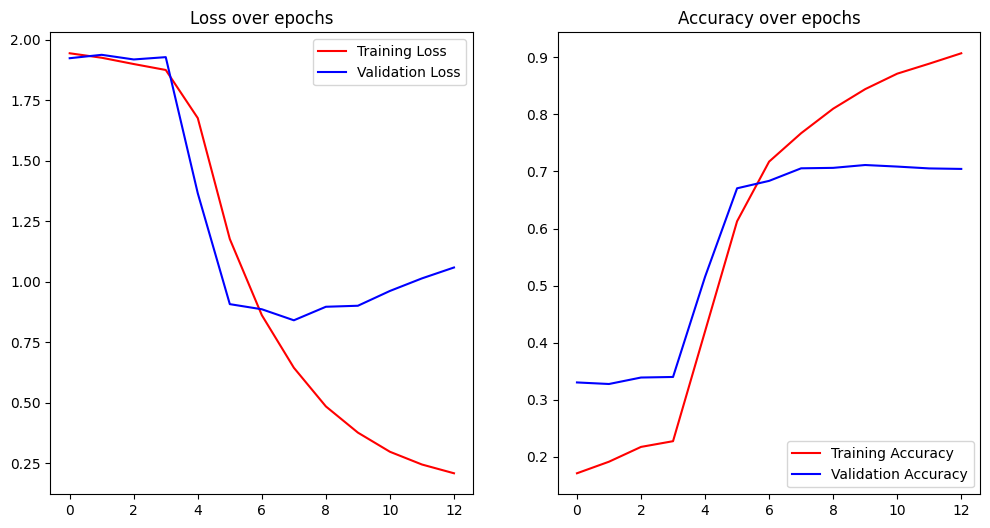

In [21]:
# Display metrics for model C, which had the best results
display_metrics(history_c)

In [22]:
# Create classification report for model C
from sklearn.metrics import classification_report
y_pred = model_c.predict(X_test_vectorized)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)
print(classification_report(y_test, y_pred, target_names=status.index))

320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
                      precision    recall  f1-score   support

              Normal       0.75      0.72      0.73       738
          Depression       0.70      0.72      0.71       508
            Suicidal       0.67      0.62      0.64      2989
             Anxiety       0.93      0.87      0.90      3294
             Bipolar       0.43      0.45      0.44       194
              Stress       0.42      0.48      0.45       454
Personality disorder       0.56      0.67      0.61      2038

            accuracy                           0.71     10215
           macro avg       0.64      0.65      0.64     10215
        weighted avg       0.72      0.71      0.72     10215



## Conclusion
* In this notebook, the EDA investigated the distribution of different mental statuses and revealed depression was the most common mental health issue
* The best performing model was utilised an LSTM layer along with a dropout layer for regularisation
* This model achieved around 71% accuracy and 66% average f1-score
* The model was best at identifying anxiety and worst at identifying bipolar
* The relatively low recall (54%) for category 'Suicidal' indicates a large quantity of false negatives which is a concern for this model if it was being used to support potentially suicidal people
* This notebook could be improved by prioritising recall as the key metric due to the use case and incorporating methods that would improve the model interpretability
